In [1]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
import matplotlib.pyplot as plt

In [2]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [3]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

# Load dat from eyelink.mat object, extract fixation times, eye positions and eyelink trial timestamps
el = h5py.File(prefix + day_dir + "/session01/eyelink.mat")
el = el.get('el').get('data')
el_trial_timestamps = np.array(el.get('trial_timestamps'))
fix_times = np.array(el.get('fix_times'))
eye_pos = np.array(el.get('eye_pos'))

In [4]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Get durations of each navigation phase
nav_intervals = trial_timestamps[1:,:].T
nav_durations = nav_intervals[:,1] - nav_intervals[:,0]
nav_durations = nav_durations.astype(np.int8)

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

# Further differentiate trial markers into trial trajectories (start poster, end poster)
trial_trajectories = np.zeros((trial_markers.shape[0], 2))
trial_trajectories[:,1] = trial_markers
trial_trajectories[1:,0] = trial_markers[:-1]
# trial_trajectories[0,0] = 0 

In [5]:
# Extract fixation events during trial periods that correspond with looking at the hint image
hints_per_trial = [np.empty((0,2)) for _ in range(el_trial_timestamps.shape[1])]
eye_x_range = (833.3, 1086.7)
eye_y_range = (900, 1066.7)

def find_floor(arr, x):
    for i, val in enumerate(arr):
        if x < val:
            return i-1
    return len(arr)-1
    
def find_ceil(arr, x):
    for i, val in enumerate(arr):
        if x <= val:
            return i
    return -1

for idx, fix_start in enumerate(fix_times[0,:]):
    # Check if it occurs during a trial, and which one
    i1 = find_floor(el_trial_timestamps[1,:], fix_start)
    i2 = find_ceil(el_trial_timestamps[2,:], fix_start)
    if i1 == i2:
        # Occurs during a trial
        eye_x, eye_y = eye_pos[0,int(fix_start-1)], eye_pos[1,int(fix_start-1)]
        if (eye_x >= eye_x_range[0] and eye_x <= eye_x_range[1]) and \
            (eye_y >= eye_y_range[0] and eye_y <= eye_y_range[1]):
            fix_end = fix_times[1,idx]
            hints_per_trial[i1] = np.vstack([hints_per_trial[i1], np.array([fix_start, fix_end]).astype(np.int64)])

# Convert the eyelink time to trial time in hint occurences
def convert_eyelink_time(trial, el_time, time, intvls):
    res = np.empty_like(intvls)
    for i, intvl in enumerate(intvls):
        st, ed = intvl
        el_st, el_ed = el_time[1:,trial]
        t_st, t_ed = time[1:,trial]
        res[i,0] = ((st - el_st) / (el_ed - el_st)) * (t_ed - t_st) + t_st
        res[i,1] = ((ed - el_st) / (el_ed - el_st)) * (t_ed - t_st) + t_st
    return res

for i, trial in enumerate(hints_per_trial):
    if trial.shape[0] > 0:
        hints_per_trial[i] = convert_eyelink_time(i, el_trial_timestamps, trial_timestamps, trial)


In [6]:
# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(trial_markers.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(nav_durations):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_markers = trial_markers[trial_filt]
trial_trajectories = trial_trajectories[trial_filt,:][0]  # not sure why it adds an extra axis
cue_intervals = cue_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
nav_intervals = nav_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
nav_durations = nav_durations[trial_filt]
trial_intervals = trial_intervals[trial_filt]
new_hints_per_trial = list()
for num, trial in enumerate(hints_per_trial):
    if good_trials[num] == 1:
        new_hints_per_trial.append(trial)
hints_per_trial = new_hints_per_trial

In [7]:
# Check number of fixation events per trial
num_hints_per_trial = list(map(lambda arr: arr.shape[0], hints_per_trial))
total_num_hints = sum(num_hints_per_trial)
print(total_num_hints)

97


In [8]:
# Check duration of fixation events per trial
hint_durs = list()
for trial in hints_per_trial:
    for intvl in trial:
        hint_durs.append(intvl[1] - intvl[0])
hint_durs = np.array(hint_durs)
print(np.mean(hint_durs))

0.2342268723633108


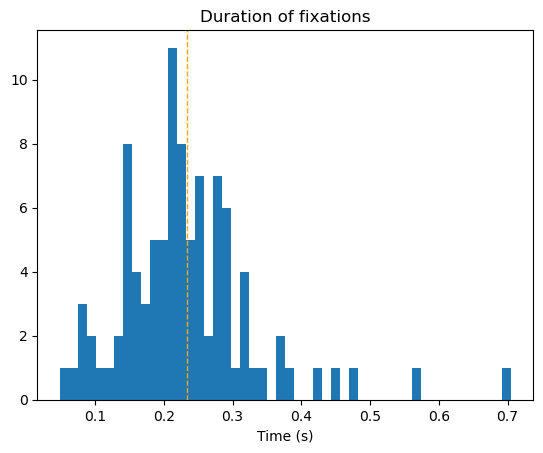

In [9]:
# Plot duration of fixation events as a histogram
plt.figure()
plt.title('Duration of fixations')
plt.hist(hint_durs, bins=50)
plt.axvline(x=np.mean(hint_durs), color='orange', linewidth=1, linestyle='--')
plt.xlabel('Time (s)')
plt.show()

In [10]:
# Bin entire session into 250 ms time bins, aligned to the start of each cue phase for each trial
session_intervals = list()
delta = 0.25  # Size of time bin (in seconds)
num_prds = int(1/delta)
for idx, intvl in enumerate(trial_intervals):
    trial_start, trial_end = intvl
    for time in np.arange(trial_start, trial_end - delta, delta):
        session_intervals.append(np.array([time, time + delta]))
session_intervals = np.array(session_intervals)

# Divide cue phases into 250 ms time bins
new_cue_intervals = np.empty((cue_intervals.shape[0], cue_intervals.shape[1], num_prds))
for num, intvl in enumerate(cue_intervals):
    st_time, ed_time = intvl
    for prd in range(num_prds):
        new_cue_intervals[num,0,prd] = st_time + delta * prd
        new_cue_intervals[num,1,prd] = st_time + delta * (prd + 1)
full_cue_intervals = cue_intervals
cue_intervals = new_cue_intervals

# Get last 1 second of navigation phases and divide into 250 ms time bins
navend_intervals = np.empty((nav_intervals.shape[0], nav_intervals.shape[1], num_prds))
for num, intvl in enumerate(nav_intervals):
    st_time, ed_time = intvl
    for prd in range(num_prds):
        navend_intervals[num,0,prd] = (ed_time - 1) + delta * prd
        navend_intervals[num,1,prd] = (ed_time - 1) + delta * (prd + 1)

Change time window here

In [11]:
# Choose which 250ms timebin to use for cue intervals to be fitted to the model
timebin_window = 2  # 0-indexed
cue_intervals = cue_intervals[:,:,timebin_window]
timebin_labels = ['0-250ms', '250-500ms', '500-750ms', '750ms-1s']

In [12]:
# Get number of cells in dataset
num_cells = len(cell_labels)

# Slot spikes into cue phase intervals for each trial
spikerates_cue = spike_rates_per_observation(cue_intervals, spike_times)

# Slot spikes into session time intervals
spikerates_session = spike_rates_per_observation(session_intervals, spike_times)

# Slot spikes into hint time intervals
spikerates_hints = [np.array([]) for _ in hints_per_trial]
for i, trial in enumerate(hints_per_trial):
    if trial.shape[0] > 0:
        spikerates_hints[i] = spike_rates_per_observation(trial, spike_times)

# Slot spikes into navigation end phase intervals for each trial
spikerates_navend = np.empty((navend_intervals.shape[0], num_cells, navend_intervals.shape[2]))
for prd in range(navend_intervals.shape[2]):
    spikerates_navend[:,:,prd] = spike_rates_per_observation(navend_intervals[:,:,prd], spike_times)

In [13]:
# Bin spike rates within each cell for entire sesion, and get firing rate thresholds used for binning
binned_spikes_session = np.empty_like(spikerates_session)
binning_stats = list()
for col in range(spikerates_session.shape[1]):
    binned_spikes_session[:,col] = bin_firing_rates_4(spikerates_session[:,col])
    binning_stats.append(get_binning_stats_4(spikerates_session[:,col]))

# Bin spike rates within each cell for cue phases
binned_spikes_cue = np.empty_like(spikerates_cue)
for col in range(spikerates_cue.shape[1]):
    binned_spikes_cue[:,col] = bin_firing_rates_4(spikerates_cue[:,col], stats=binning_stats[col])

# Bin spike rates within each cell for hint periods
binned_spikes_hints = [np.empty_like(arr) for arr in spikerates_hints]
for i, trial in enumerate(spikerates_hints):
    if trial.shape[0] > 0:
        for col in range(num_cells):
            binned_spikes_hints[i][:,col] = bin_firing_rates_4(trial[:,col], stats=binning_stats[col])

# Bin spike rates within each cell for navigation end phases
binned_spikes_navend = np.empty_like(spikerates_navend)
for prd in range(spikerates_navend.shape[2]):
    for col in range(spikerates_navend.shape[1]):
        binned_spikes_navend[:,col,prd] = bin_firing_rates_4(spikerates_navend[:,col,prd], stats=binning_stats[col])

In [14]:
# Format data into X and y matrices
cue_responses_binned = binned_spikes_cue
cue_responses_raw = spikerates_cue
cue_markers = trial_markers
num_goals = 6

In [15]:
def train_test_split(X: np.array, y: np.array, split: tuple) -> tuple:
    # itr: current iteration of k-fold validation
    # way: value of k in k-fold validation
    itr, way = split
    X_train, X_test = list(), list()
    y_train, y_test = list(), list()
    for num, obs in enumerate(X):
        if num % way == itr:
            X_test.append(obs)
            y_test.append(y[num])
        else:
            X_train.append(obs)
            y_train.append(y[num])
    # Return format: X_train, X_test, y_train, y_test   
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

def prediction_accuracy(y_pred: np.array, y_actl: np.array) -> float:
    count, total = 0, y_actl.shape[0]
    for num, obs in enumerate(y_pred):
        if obs == y_actl[num]:
            count += 1
    return count / total

def confusion_matrix(y_pred: np.array, y_actl: np.array, res: np.array) -> np.array:
    for pred, actl in zip(y_pred, y_actl):
        pred, actl = int(pred - 1), int(actl - 1)
        res[pred, actl] += 1
    return res

In [16]:
# Build decoder for 6+1 classes
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# LDA, binned
k_fold = 10
prob_mins = np.zeros(k_fold)
accuracies = np.zeros(k_fold)
conf_mat = np.zeros((num_goals, num_goals))
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(cue_responses_binned, cue_markers, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    # lda = QuadraticDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_test)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    prob_mins[i] = np.min(y_pred_proba)
    accuracies[i] = prediction_accuracy(y_pred, y_test)
    conf_mat = confusion_matrix(y_pred, y_test, conf_mat)

prob_thresh = np.mean(prob_mins)
print(prob_thresh)

0.23818204591356432


In [17]:
from sklearn.svm import SVC
# SVM, binned
k_fold = 10
prob_mins2 = np.zeros(k_fold)
accuracies2 = np.zeros(k_fold)
conf_mat2 = np.zeros((num_goals, num_goals))
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(cue_responses_binned, cue_markers, (i, k_fold))
    svm = SVC(probability=True)
    # svm = SVC(kernel='poly', degree=2, probability=True)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    y_pred_proba = svm.predict_proba(X_test)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    prob_mins2[i] = np.min(y_pred_proba)
    accuracies2[i] = prediction_accuracy(y_pred, y_test)
    conf_mat2 = confusion_matrix(y_pred, y_test, conf_mat2)

prob_thresh2 = np.mean(prob_mins2)
print(prob_thresh2)

0.20168801894818883


In [18]:
# LDA, raw counts
k_fold = 10
prob_mins3 = np.zeros(k_fold)
accuracies3 = np.zeros(k_fold)
conf_mat3 = np.zeros((num_goals, num_goals))
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(cue_responses_raw, cue_markers, (i, k_fold))
    lda = LinearDiscriminantAnalysis()
    # lda = QuadraticDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_test)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    prob_mins3[i] = np.min(y_pred_proba)
    accuracies3[i] = prediction_accuracy(y_pred, y_test)
    conf_mat3 = confusion_matrix(y_pred, y_test, conf_mat3)

prob_thresh3 = np.mean(prob_mins3)
print(prob_thresh3)

0.2512755290476025


In [19]:
# SVM, raw counts
k_fold = 10
prob_mins4 = np.zeros(k_fold)
accuracies4 = np.zeros(k_fold)
conf_mat4 = np.zeros((num_goals, num_goals))
for i in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(cue_responses_raw, cue_markers, (i, k_fold))
    svm = SVC(probability=True)
    # svm = SVC(kernel='poly', degree=2, probability=True)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    y_pred_proba = svm.predict_proba(X_test)
    y_pred_proba = np.max(y_pred_proba, axis=1)
    prob_mins4[i] = np.min(y_pred_proba)
    accuracies4[i] = prediction_accuracy(y_pred, y_test)
    conf_mat4 = confusion_matrix(y_pred, y_test, conf_mat4)

prob_thresh4 = np.mean(prob_mins4)
print(prob_thresh4)

0.21272181285320121


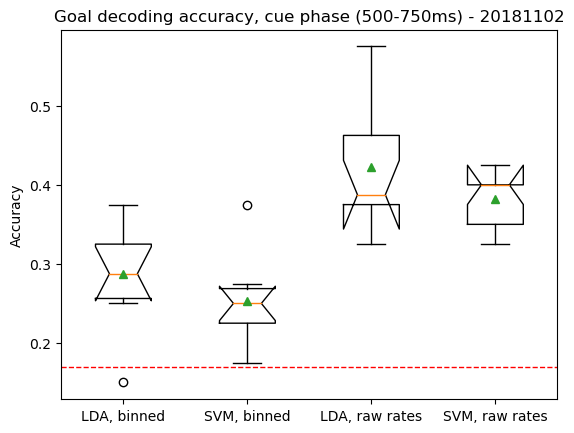

In [20]:
# Plot variance in prediciton accuracy between different folds
plt.figure()
plt.title(f'Goal decoding accuracy, cue phase ({timebin_labels[timebin_window]}) - {day_dir}')
plt.boxplot([accuracies, accuracies2, accuracies3, accuracies4], showmeans=True, notch=True)
plt.axhline(y=0.17, color='r', linewidth=1, linestyle='--')
plt.xticks(np.arange(1, 5), labels=['LDA, binned', 'SVM, binned', 'LDA, raw rates', 'SVM, raw rates'])
plt.ylabel('Accuracy')
plt.show()

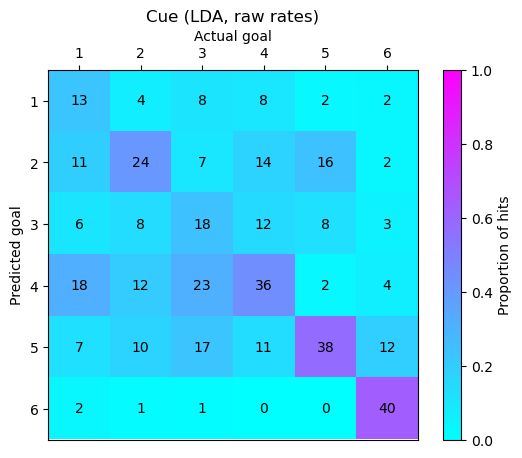

In [21]:
# Plot confusion matrix
# Convert counts to proportion of predictions
conf_mat_title = 'Cue (LDA, raw rates)'  # Select which confusion matrix to plot
conf_mat_plot = conf_mat3
num_goals = conf_mat_plot.shape[0]
col_sums = np.sum(conf_mat_plot, axis=0)
conf_mat_prop = np.empty_like(conf_mat_plot)
for col, val in enumerate(col_sums):
    conf_mat_prop[:,col] = conf_mat_plot[:,col] / val

plt.figure()
ax = plt.gca()
plt.title(conf_mat_title)
plt.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
plt.colorbar(label='Proportion of hits')
plt.xticks(np.arange(num_goals), labels=np.arange(1, num_goals+1))
plt.yticks(np.arange(num_goals), labels=np.arange(1, num_goals+1))
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xlabel('Actual goal')
plt.ylabel('Predicted goal')
ax.xaxis.set_label_position('top')
for i, row in enumerate(conf_mat_plot):
    for j, val in enumerate(row):
        ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')

In [22]:
class ResponseClassifier():
    def __init__(self, model):
        self.model = model

    def fit(self, X, y, thresh):
        self.model.fit(X, y)
        self.thresh = thresh

    def predict(self, X):
        classes = self.model.predict(X)
        probs = self.model.predict_proba(X)
        filt = np.where(np.max(probs, axis=1) < self.thresh)
        classes[filt] = 0
        return classes

In [23]:
def confusion_matrix_2(preds_per_trial: np.array, actl_per_trial: np.array, num_classes: int) -> np.array:
    res = np.zeros((num_classes, num_classes))
    for idx, trial in enumerate(preds_per_trial):
        actl = int(actl_per_trial[idx]) - 1
        for pred in trial:
            pred = int(pred - 1)
            res[pred, actl] += 1
    return res

def prediction_accuracy_2(conf_mat: np.array) -> float:
    num_classes = conf_mat.shape[0]
    count, total = 0, np.sum(np.sum(conf_mat))
    for i in range(num_classes):
        count += conf_mat[i,i]
    return count / total

def prediction_accuracy_3(preds_per_trial: np.array, actl_per_trial: np.array) -> np.array:
    res = list()
    for idx, trial in enumerate(preds_per_trial):
        actl = actl_per_trial[idx]
        cnt, hit = 0, 0
        for pred in trial:
            if pred == actl:
                hit += 1
            cnt += 1
        if cnt > 0:
            res.append(hit/cnt)
    return np.array(res)

In [24]:
model_binned = ResponseClassifier(LinearDiscriminantAnalysis())
# model_binned = ResponseClassifier(SVC(probability=True))
model_binned.fit(cue_responses_binned, cue_markers, prob_thresh)

hint_preds_binned = list()
for trial in binned_spikes_hints:
    if trial.shape[0] > 0:
        hint_preds_binned.append(model_binned.predict(trial))
    else:
        hint_preds_binned.append(trial)
confmat_hint_binned = confusion_matrix_2(hint_preds_binned, trial_markers, 7)
acc_hint_binned = prediction_accuracy_2(confmat_hint_binned)
accdist_hint_binned = prediction_accuracy_3(hint_preds_binned, trial_markers)

navend_preds_binned = np.empty((binned_spikes_navend.shape[0], binned_spikes_navend.shape[2]))
for prd in range(binned_spikes_navend.shape[2]):
    navend_preds_binned[:,prd] = model_binned.predict(binned_spikes_navend[:,:,prd])
confmat_navend_binned = confusion_matrix_2(navend_preds_binned, trial_markers, 7)
acc_navend_binned = prediction_accuracy_2(confmat_navend_binned)
accdist_navend_binned = prediction_accuracy_3(navend_preds_binned, trial_markers)

In [25]:
model_raw = ResponseClassifier(LinearDiscriminantAnalysis())
# model_raw = ResponseClassifier(SVC(probability=True))
model_raw.fit(cue_responses_raw, cue_markers, prob_thresh3)

hint_preds_raw = list()
for trial in spikerates_hints:
    if trial.shape[0] > 0:
        hint_preds_raw.append(model_raw.predict(trial))
    else:
        hint_preds_raw.append(trial)
confmat_hint_raw = confusion_matrix_2(hint_preds_raw, trial_markers, 7)
acc_hint_raw = prediction_accuracy_2(confmat_hint_raw)
accdist_hint_raw = prediction_accuracy_3(hint_preds_raw, trial_markers)

navend_preds_raw = np.empty((spikerates_navend.shape[0], spikerates_navend.shape[2]))
for prd in range(spikerates_navend.shape[2]):
    navend_preds_raw[:,prd] = model_raw.predict(spikerates_navend[:,:,prd])
confmat_navend_raw = confusion_matrix_2(navend_preds_raw, trial_markers, 7)
acc_navend_raw = prediction_accuracy_2(confmat_navend_raw)
accdist_navend_raw = prediction_accuracy_3(navend_preds_raw, trial_markers)

In [26]:
print(f'--- Decoding accuracies ---\n\
Hint, binned: {acc_hint_binned}\nHint, raw: {acc_hint_raw}\n\
Navend, binned: {acc_navend_binned}\nNavend, raw: {acc_navend_raw}')

--- Decoding accuracies ---
Hint, binned: 0.14432989690721648
Hint, raw: 0.13402061855670103
Navend, binned: 0.195625
Navend, raw: 0.2175


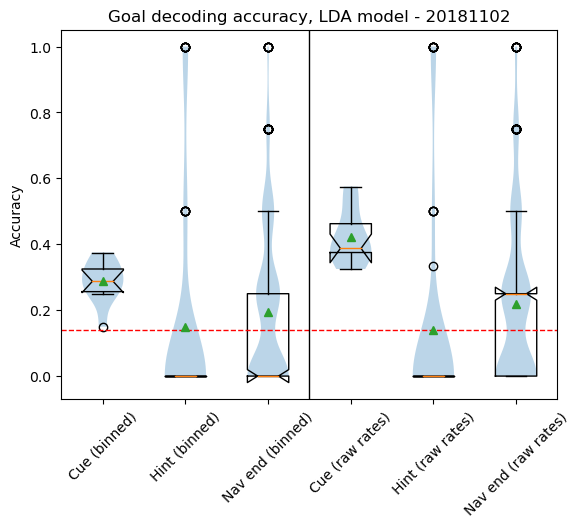

In [27]:
# Plot variance in prediciton accuracy between datasets
accuracy_list = [accuracies, accdist_hint_binned, accdist_navend_binned, accuracies3, accdist_hint_raw, accdist_navend_raw]
labels_list = ['Cue (binned)', 'Hint (binned)', 'Nav end (binned)', 'Cue (raw rates)', 'Hint (raw rates)', 'Nav end (raw rates)']

plt.figure()
plt.title(f'Goal decoding accuracy, LDA model - {day_dir}')
plt.boxplot(accuracy_list, showmeans=True, notch=True)
plt.violinplot(accuracy_list, showextrema=False)
plt.axhline(y=0.14, color='r', linewidth=1, linestyle='--')
plt.axvline(x=3.5, color='k', linewidth=1)
plt.xticks(np.arange(1, 7), labels=labels_list, rotation=45)
plt.ylabel('Accuracy')
plt.show()

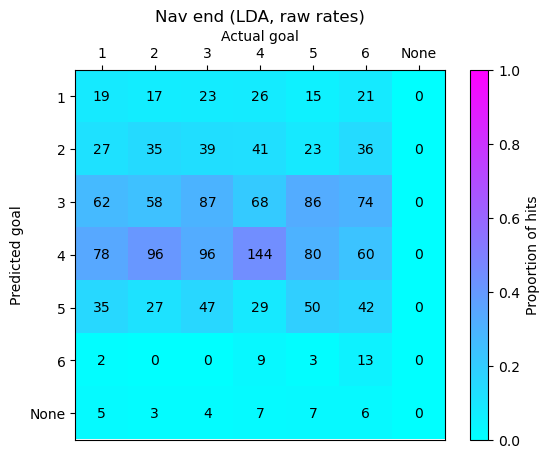

In [28]:
# Plot confusion matrix
# Convert counts to proportion of predictions
conf_mat_title2 = 'Nav end (LDA, raw rates)'  # Select which confusion matrix to plot
conf_mat_plot2 = confmat_navend_raw
num_goals2 = conf_mat_plot2.shape[0]
col_sums2 = np.sum(conf_mat_plot2, axis=0)
conf_mat_prop2 = np.empty_like(conf_mat_plot2)
for col, val in enumerate(col_sums2):
    conf_mat_prop2[:,col] = np.divide(conf_mat_plot2[:,col], val, out=np.zeros_like(conf_mat_plot2[:,col]), where=val!=0)

plt.figure()
ax = plt.gca()
plt.title(conf_mat_title2)
plt.imshow(conf_mat_prop2, cmap='cool', vmin=0, vmax=1)
plt.colorbar(label='Proportion of hits')
tick_labels = list(range(1, num_goals2))
tick_labels.append('None')
plt.xticks(np.arange(num_goals2), labels=tick_labels)
plt.yticks(np.arange(num_goals2), labels=tick_labels)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xlabel('Actual goal')
plt.ylabel('Predicted goal')
ax.xaxis.set_label_position('top')
for i, row in enumerate(conf_mat_plot2):
    for j, val in enumerate(row):
        ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')